<a href="https://colab.research.google.com/github/shubhpanchal/BikeSharing/blob/main/Bike_Sharing_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime as dt

# Importing Data Viz Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mounting the drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/Almabetter/Alma Capstone Projects Folder/Supervised ML Regression/Bike Sharing Demand Prediction/SeoulBikeData.csv',
                   encoding='ISO-8859-1')

# creating the copy of original data so thatwe do not loose original data accidentally
bike_df = data.copy()

# First look at the data
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Understanding the Data.


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [5]:
# Lets check the missing values
pd.concat([bike_df.isnull().sum(),round(100*(bike_df.isnull().sum()/len(bike_df)),2)],axis = 1,keys=['Missing Values','% Missing Values'])

,Missing Values,% Missing Values
Date,0,0.0
Rented Bike Count,0,0.0
Hour,0,0.0
Temperature(°C),0,0.0
Humidity(%),0,0.0
Wind speed (m/s),0,0.0
Visibility (10m),0,0.0
Dew point temperature(°C),0,0.0
Solar Radiation (MJ/m2),0,0.0
Rainfall(mm),0,0.0


There are no missing values in the dataset

## Feature Engineering

In [6]:
# Creating Columns that are related to time data
bike_df['Date'] = pd.to_datetime(bike_df['Date'])
bike_df['Year'] = bike_df['Date'].dt.year
bike_df['Month'] = bike_df['Date'].dt.month
bike_df['Day'] = bike_df['Date'].dt.day
bike_df['Day_name'] = bike_df['Date'].dt.day_name()

# Looking at the data
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day,Day_name
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1,12,Thursday


In [7]:
# Renaming the columns
bike_df.rename(columns={'Temperature(°C)': 'Temperature', 'Humidity(%)': 'Humidity','Wind speed (m/s)':'Wind Speed',
                        'Visibility (10m)':'Visibility','Dew point temperature(°C)':'Dew Point Temp','Solar Radiation (MJ/m2)':'Solar Radiation',
                        'Rainfall(mm)':'Rainfall','Snowfall (cm)':'Snowfall'}, inplace=True)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               8760 non-null   datetime64[ns]
 1   Rented Bike Count  8760 non-null   int64         
 2   Hour               8760 non-null   int64         
 3   Temperature        8760 non-null   float64       
 4   Humidity           8760 non-null   int64         
 5   Wind Speed         8760 non-null   float64       
 6   Visibility         8760 non-null   int64         
 7   Dew Point Temp     8760 non-null   float64       
 8   Solar Radiation    8760 non-null   float64       
 9   Rainfall           8760 non-null   float64       
 10  Snowfall           8760 non-null   float64       
 11  Seasons            8760 non-null   object        
 12  Holiday            8760 non-null   object        
 13  Functioning Day    8760 non-null   object        
 14  Year    

## Defining Helper Functions

In [8]:
# Creating a categorical column that represents weekends(saturdays and Sundays)
def weekend(Day_name):
  if (Day_name == 'Saturday'or Day_name =='Sunday'):
    return 1
  else:
    return 0
bike_df['is_weekend'] = bike_df['Day_name'].apply(weekend)

bike_df.head()

# Transforming numerical columns into binary columns for Snowfall, Rainfall and Solar Radiation
def binary_transformation(col):
  if (col > 0):
    return 1
  else:
    return 0

bike_df['Snowfall'] = bike_df['Snowfall'].apply(binary_transformation)
bike_df['Rainfall'] = bike_df['Rainfall'].apply(binary_transformation)
bike_df['Solar Radiation'] = bike_df['Solar Radiation'].apply(binary_transformation)

# Transforming the Visibility Column into Binary Column
def visibility(col):
  if(col<1436.825799):
    return 0
  else:
    return 1

bike_df['Visibility'] = bike_df['Visibility'].apply(visibility)

bike_df.nunique()

Date                  365
Rented Bike Count    2166
Hour                   24
Temperature           546
Humidity               90
Wind Speed             65
Visibility              2
Dew Point Temp        556
Solar Radiation         2
Rainfall                2
Snowfall                2
Seasons                 4
Holiday                 2
Functioning Day         2
Year                    2
Month                  12
Day                    31
Day_name                7
is_weekend              2
dtype: int64

### Changing the Column types

In [9]:
change_to_object =  ['Year','Month','is_weekend','Visibility','Solar Radiation','Rainfall','Snowfall']
for col in change_to_object:
  bike_df[col]=bike_df[col].astype('str')
  print('Successfully Changed the ' + col + ' dtype to :', bike_df[col].dtype)

Successfully Changed the Year dtype to : object
Successfully Changed the Month dtype to : object
Successfully Changed the is_weekend dtype to : object
Successfully Changed the Visibility dtype to : object
Successfully Changed the Solar Radiation dtype to : object
Successfully Changed the Rainfall dtype to : object
Successfully Changed the Snowfall dtype to : object


## Data Descrition


### Data Description for Numerical Columns

In [10]:
bike_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.5,1065.25,3556.0
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.5,17.25,23.0
Temperature,8760.0,12.882922,11.944825,-17.8,3.50,13.7,22.50,39.4
Humidity,8760.0,58.226256,20.362413,0.0,42.00,57.0,74.00,98.0
Wind Speed,8760.0,1.724909,1.036300,0.0,0.90,1.5,2.30,7.4
Dew Point Temp,8760.0,4.073813,13.060369,-30.6,-4.70,5.1,14.80,27.2
Day,8760.0,15.720548,8.796749,1.0,8.00,16.0,23.00,31.0


### Data Description For Categorical Data

In [11]:
bike_df.describe(include=['object','category']).T

,count,unique,top,freq
Visibility,8760,2,1,5166
Solar Radiation,8760,2,1,4460
Rainfall,8760,2,0,8232
Snowfall,8760,2,0,8317
Seasons,8760,4,Spring,2208
Holiday,8760,2,No Holiday,8328
Functioning Day,8760,2,Yes,8465
Year,8760,2,2018,8016
Month,8760,12,1,744
Day_name,8760,7,Sunday,1296


## Dividing the Data according to their attributes

In [12]:
numeric_features = ['Temperature','Humidity','Wind Speed','Dew Point Temp']
categorical_features = ['Seasons','Holiday','Functioning Day','Year','Month','Day_name','is_weekend','Visibility','Solar Radiation','Rainfall','Snowfall','Day','Hour']
label = bike_df['Rented Bike Count']

# Exploratory Data Analysis

### Understanding the Target Variable

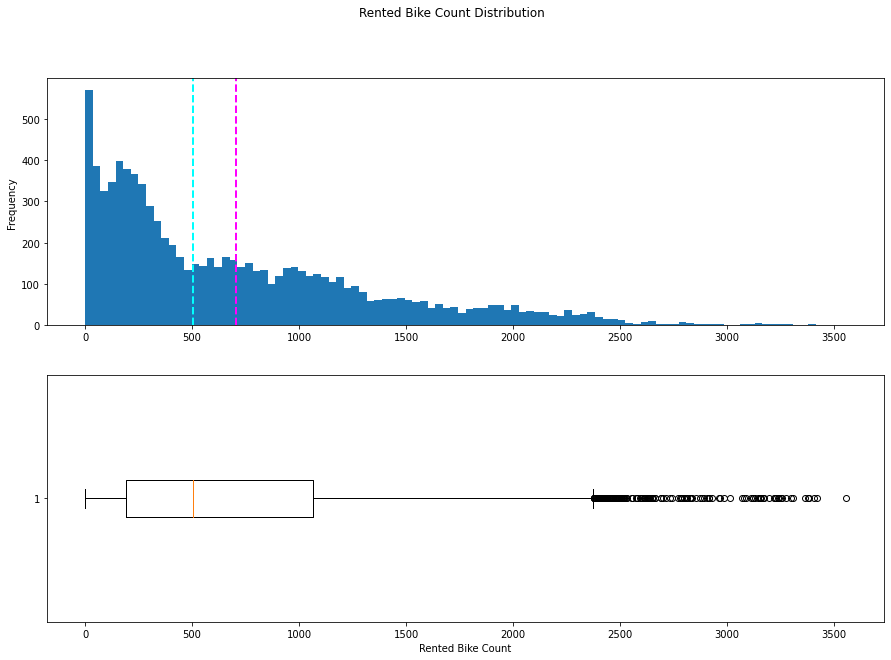

In [13]:
fig,ax = plt.subplots(2,1,figsize=(15,10))
# Plotting the histogram
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Adding vertical Lines for Mean and Median
ax[0].axvline(label.mean(),color='magenta',linestyle='dashed',linewidth=2)
ax[0].axvline(label.median(),color='cyan',linestyle='dashed',linewidth=2)

# Plotting the boxplot
ax[1].boxplot(label,vert=False)
ax[1].set_xlabel('Rented Bike Count')

# Add a title to the figure
fig.suptitle('Rented Bike Count Distribution')

# Show the figure
fig.show()



The plots show that the number of daily rentals ranges from 0 to just over 3,400. However, the mean (and median) number of daily rentals is closer to the low end of that range, with most of the data between 0 and around 2,200 rentals. The few values above this are shown in the box plot as small circles, indicating that they are outliers 

## Univariate Analysis

### Data Distribution for Numeric Columns

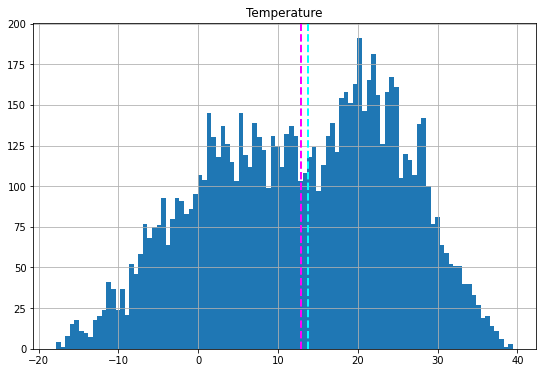

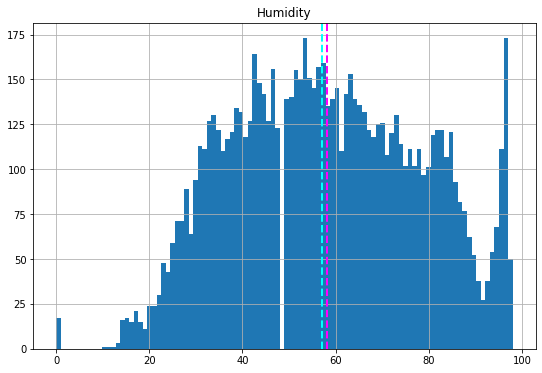

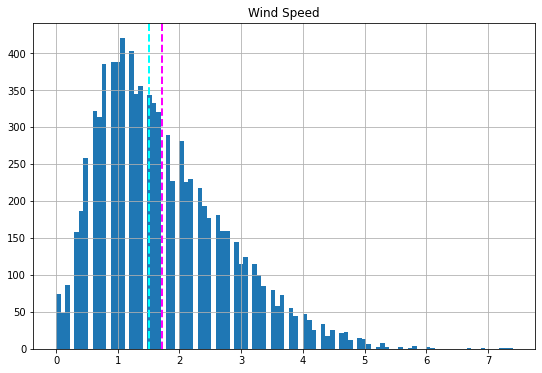

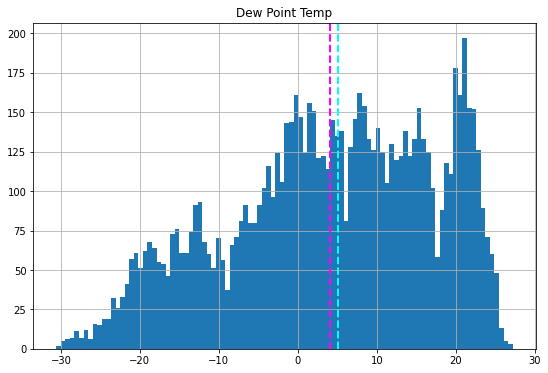

In [14]:
# Plot the histogram for each numeric feature
for col in numeric_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  feature = bike_df[col]
  feature.hist(bins=100,ax=ax)
  ax.axvline(feature.mean(), color='magenta',linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
  ax.set_title(col)
plt.show()

### Data Distribution for Categorical Variable

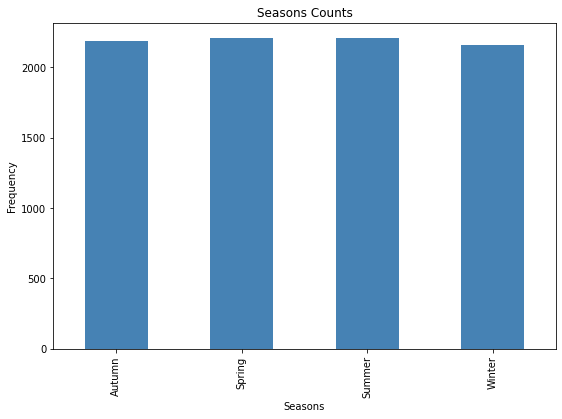

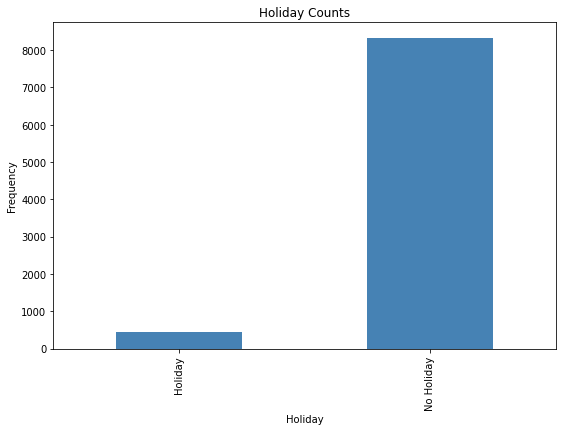

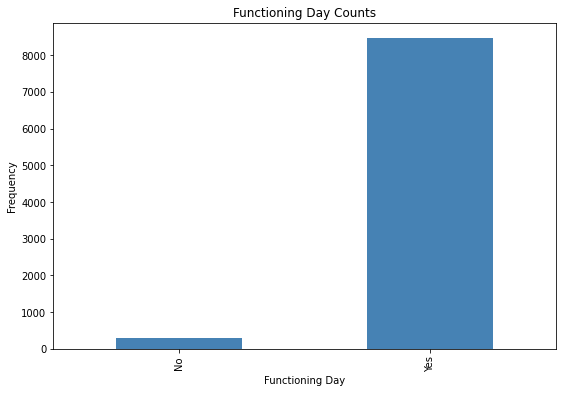

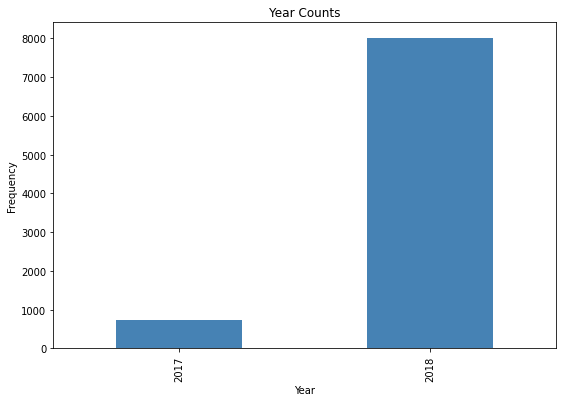

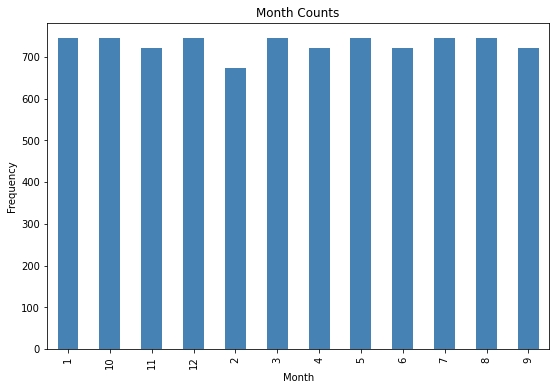

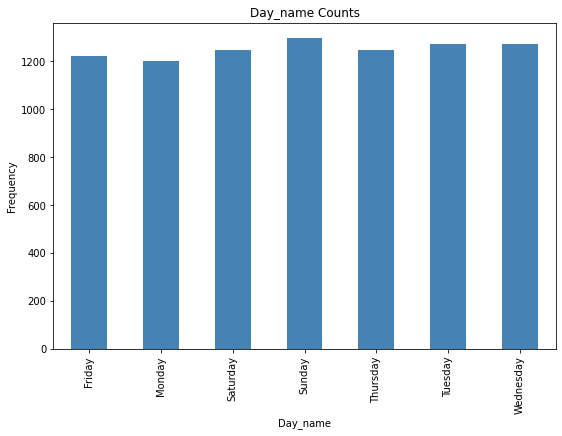

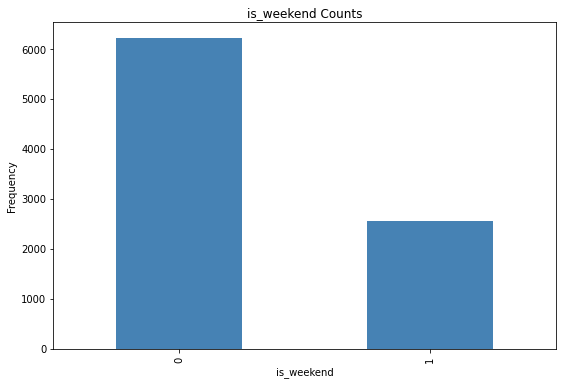

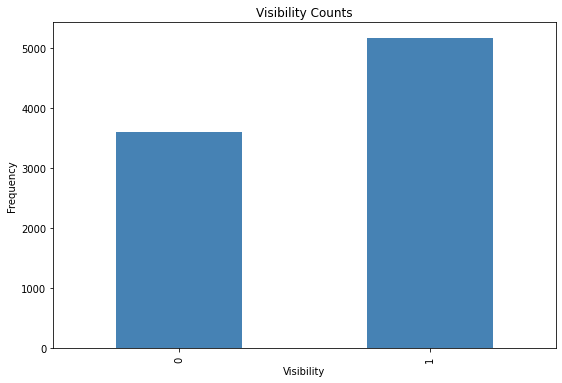

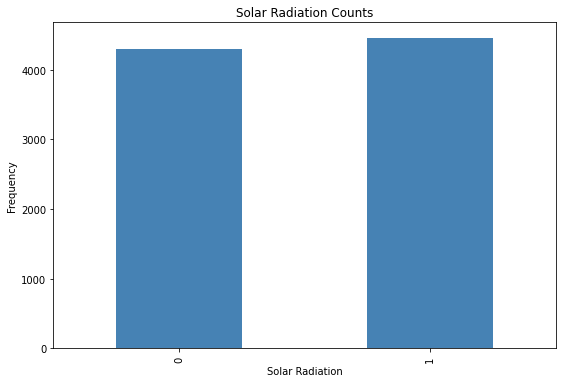

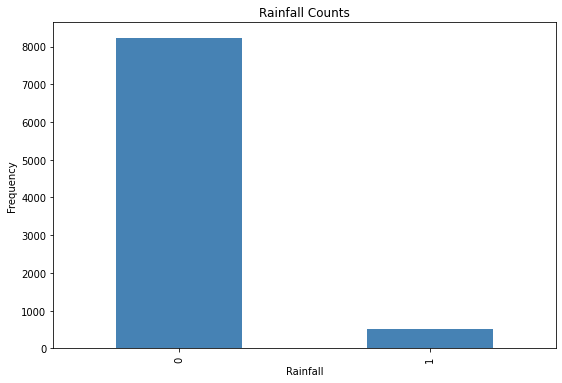

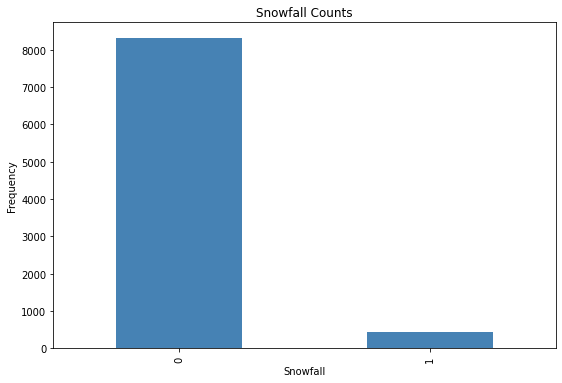

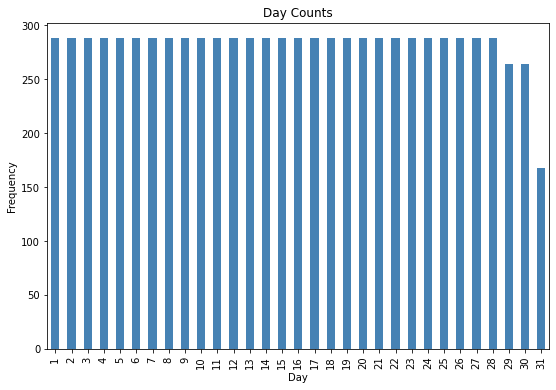

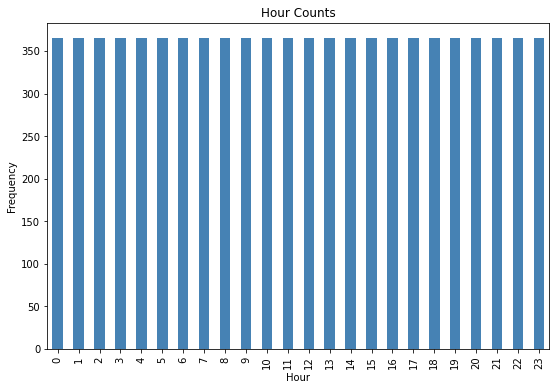

In [15]:
# Plotting the count plot for Categorical Variables
for col in categorical_features:
  counts = bike_df[col].value_counts().sort_index()
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  counts.plot.bar(ax=ax,color='steelblue')
  ax.set_title(col + ' Counts')
  ax.set_xlabel(col)
  ax.set_ylabel('Frequency')
plt.show()

## Bivariate Analysis

### Understanding Relationship of Numeric Columns with Target Variable

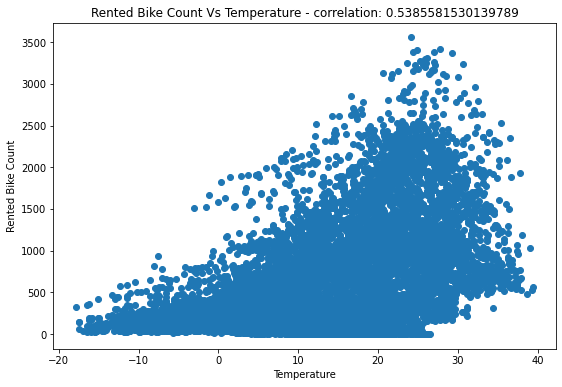

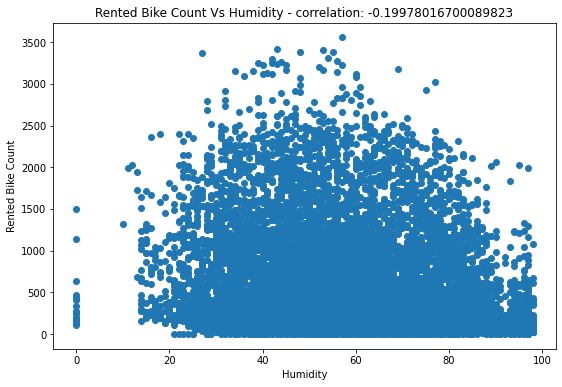

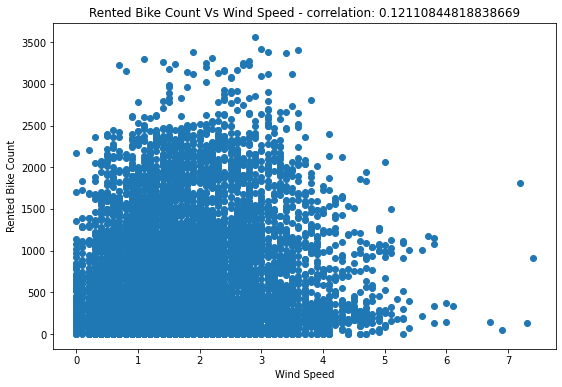

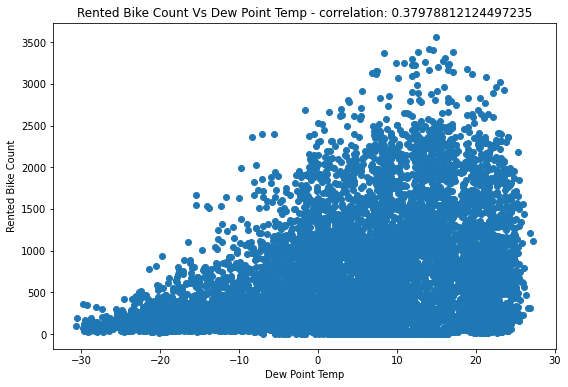

In [16]:
# Plotting regplot for numeric variables
for col in numeric_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  feature = bike_df[col]
  label = bike_df['Rented Bike Count']
  correlation = feature.corr(label)
  plt.scatter(x=feature, y=label)
  plt.xlabel(col)
  plt.ylabel('Rented Bike Count')
  ax.set_title('Rented Bike Count Vs ' + col + ' - correlation: ' + str(correlation))
plt.show()


### Understanding Relationship between Categorical Variable and Target Variable

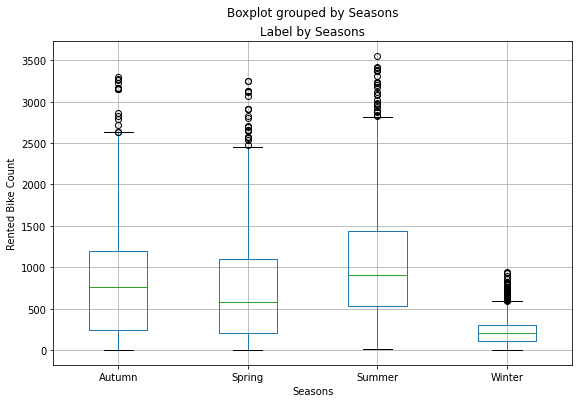

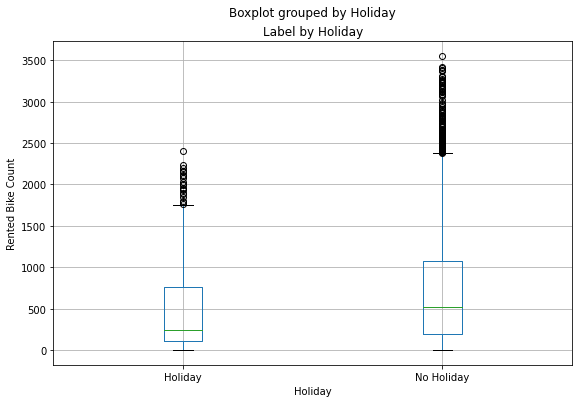

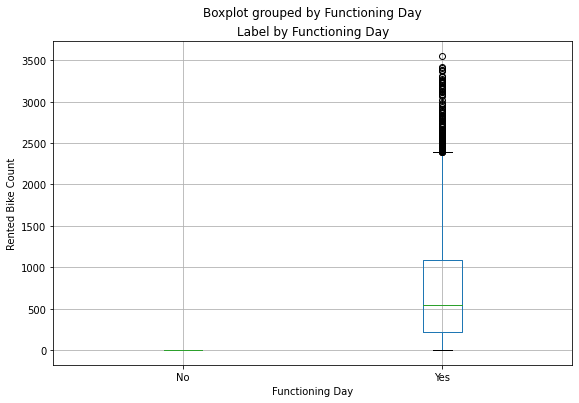

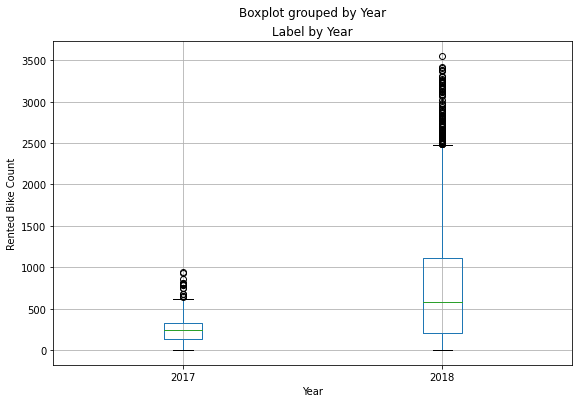

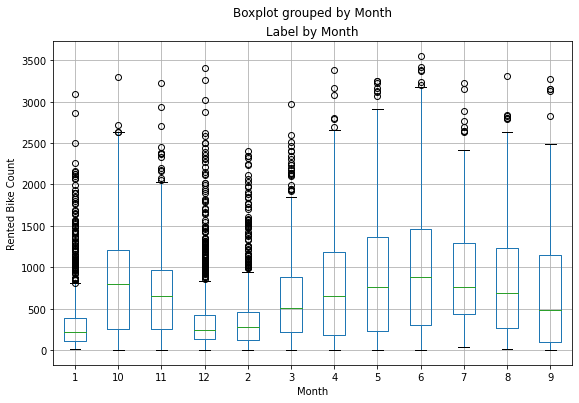

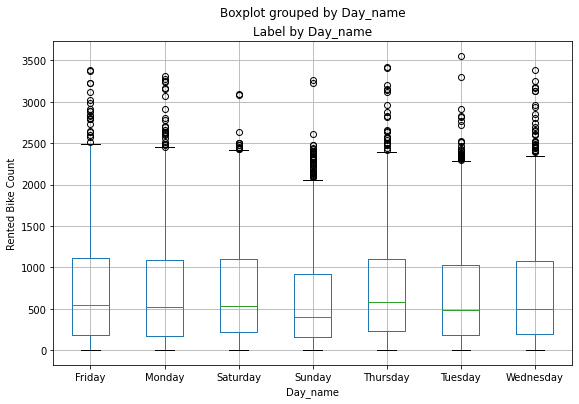

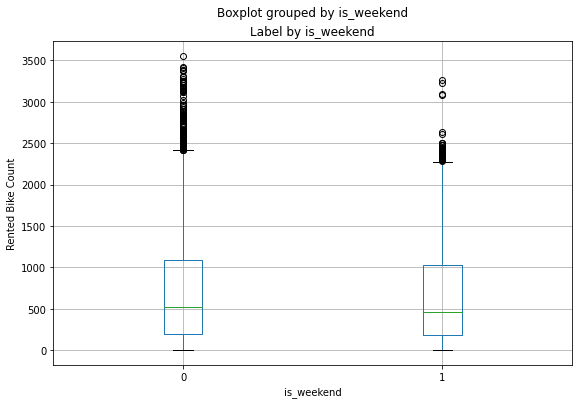

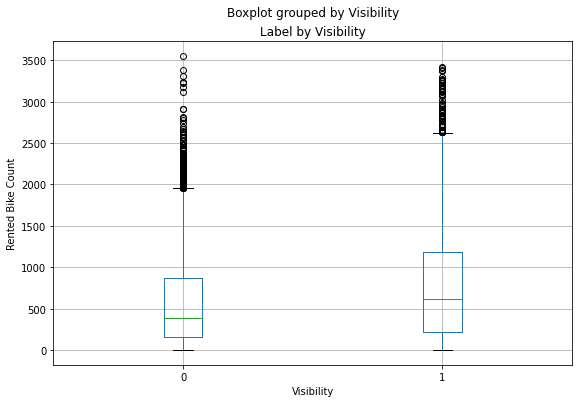

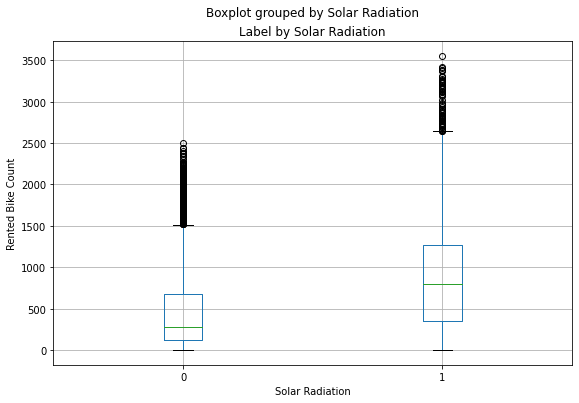

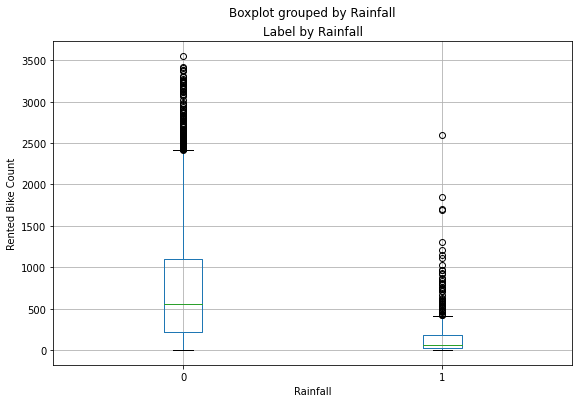

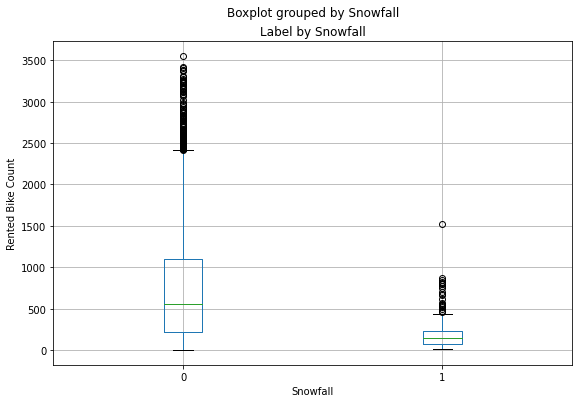

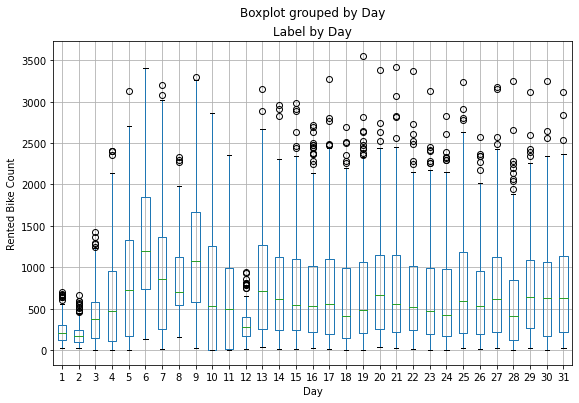

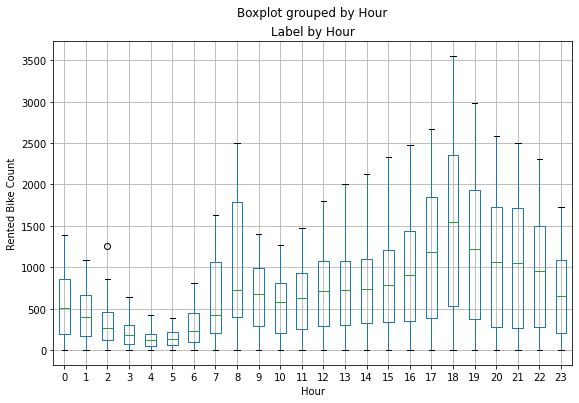

In [17]:
# Plotting a boxplot for each categorical Variable
for col in categorical_features:
  fig = plt.figure(figsize=(9,6))
  ax = fig.gca()
  bike_df.boxplot(column = 'Rented Bike Count', by = col, ax= ax)
  ax.set_title('Label by ' + col)
  ax.set_ylabel('Rented Bike Count')
plt.show()

## Multivariate Analysis

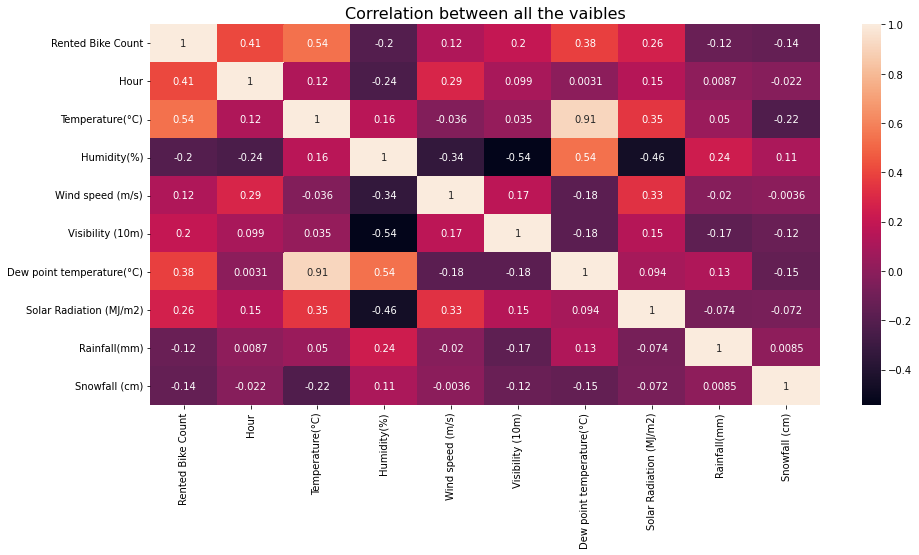

In [18]:
 #visualization of the correlation in the heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation between all the vaibles', size=16)
plt.show()

## Checking for Multicollinearity using Variance Inflation Factor

In [19]:
def cal_vif(X):
  vif = pd.DataFrame()
  vif['Variables'] = X.columns
  vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range (X.shape[1])]
  return vif

In [20]:
cal_vif(bike_df[[i for i in bike_df.describe().columns if i not in ['Temperature']]])

,Variables,VIF
0,Rented Bike Count,3.342276
1,Hour,4.738299
2,Humidity,5.006892
3,Wind Speed,3.721516
4,Dew Point Temp,1.763485
5,Day,3.708912


## Data Preprocessing

In [21]:
print('Numeric Features : ', numeric_features)
print('Categorical Features : ', categorical_features)

Numeric Features :  ['Temperature', 'Humidity', 'Wind Speed', 'Dew Point Temp']
Categorical Features :  ['Seasons', 'Holiday', 'Functioning Day', 'Year', 'Month', 'Day_name', 'is_weekend', 'Visibility', 'Solar Radiation', 'Rainfall', 'Snowfall', 'Day', 'Hour']


In [22]:
X = bike_df[['Seasons','Holiday','Functioning Day','Functioning Day','Year','Month','Visibility','Solar Radiation','Rainfall','Snowfall','Hour',
             'Humidity','Wind Speed','Dew Point Temp']].values
y = bike_df['Rented Bike Count'].values
print('Features: ',X[:10], '\nLabels: ',y[:10], sep='\n')

Features: 
[['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 0 37 2.2
  -17.6]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 1 38 0.8
  -17.6]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 2 39 1.0
  -17.7]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 3 40 0.9
  -17.6]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 4 36 2.3
  -18.6]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 5 37 1.5
  -18.7]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 6 35 1.3
  -19.5]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '0' '0' '0' 7 38 0.9
  -19.3]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '1' '0' '0' 8 37 1.1
  -19.8]
 ['Winter' 'No Holiday' 'Yes' 'Yes' '2017' '1' '1' '1' '0' '0' 9 27 0.5
  -22.4]]

Labels: 
[254 204 173 107  78 100 181 460 930 490]


### Splitting the Dataset into Training and Test Dataset

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=1)
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape: ', X_test.shape)
print('y_test Shape: ', y_test.shape)

X_train Shape:  (7008, 14)
y_train Shape:  (7008,)
X_test Shape:  (1752, 14)
y_test Shape:  (1752,)


# Data Preprocessing

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define preprocessing for categorical features(encode them)
cat_features = [0,1,2,3,4,5,6,7,8,9]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# define preprocessing for Numerical Features (Feature Scaling)
num_features =[10,11,12]
numeric_transformer = Pipeline(steps=[
    ('scaler',StandardScaler())])

# Combining Preprocessing Steps
preprocessor= ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])


# Training the Model

## 1. Linear Algorithms

### A. Linear Regression (OLS- Ordinary Least Squares)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [10, 11, 12]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                   9])])),
                ('regressor', LinearRegression())])
_____________________________________________________________________________________________________________________________
MSE : 183754.3575685322
RMSE : 428.66578772807634
R2 Score : 0.555387018943124
__________________________________________

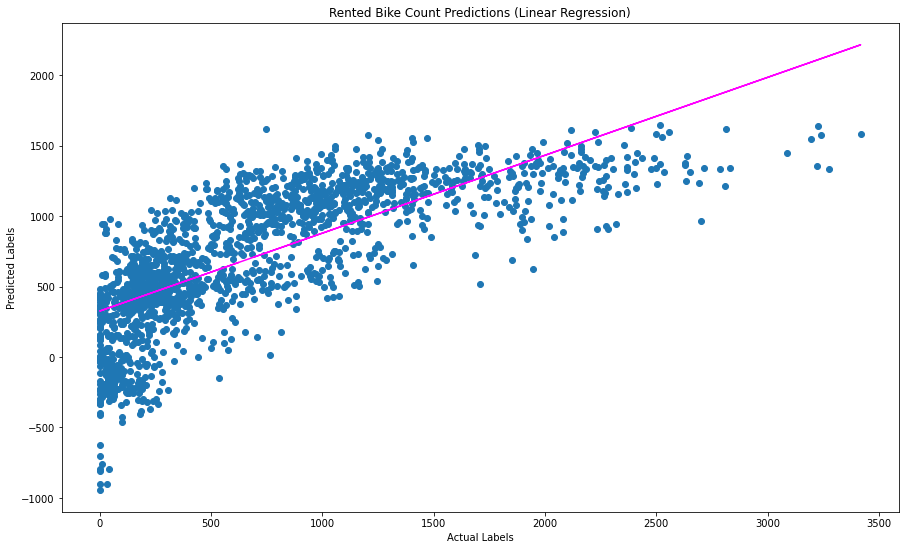

In [56]:
from sklearn.linear_model import LinearRegression

# Create Preprocessing and Training Pipeline
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', LinearRegression())])

# Fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train,(y_train))
print(model)
print('_'*125)

# Get Predictions
predictions = model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
mse = mean_squared_error(y_test, predictions)
print('MSE :', mse)
rmse = np.sqrt(mse)
print('RMSE :', rmse)
r2 = r2_score(y_test,predictions)
print('R2 Score :', r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Linear Regression)')
z= np.polyfit(y_test, predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

### B. Lasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [10, 11, 12]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                   9])])),
                ('regressor', Lasso())])
_____________________________________________________________________________________________________________________________
MSE : 184327.2441531074
RMSE : 429.33348827351847
R2 Score : 0.5540008596403142
____________________________________________________

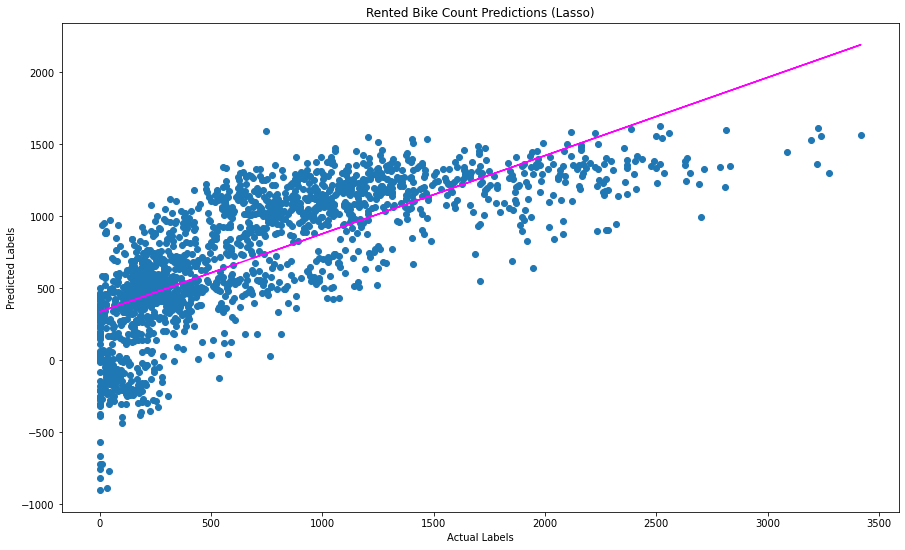

In [55]:
from sklearn.linear_model import Lasso

# Create Preprocessing and Training Pipeline
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', Lasso())])

# Fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train,(y_train))
print(model)
print('_'*125)

# Get Predictions
predictions = model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
mse = mean_squared_error(y_test, predictions)
print('MSE :', mse)
rmse = np.sqrt(mse)
print('RMSE :', rmse)
r2 = r2_score(y_test,predictions)
print('R2 Score :', r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Lasso)')
z= np.polyfit(y_test, predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

## 2. Ensemble Algorithms

### A. Random Forest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [10, 11, 12]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                   9])])),
                ('regressor', RandomForestRegressor())])
_____________________________________________________________________________________________________________________________
MSE : 82048.93625246099
RMSE : 286.4418549242778
R2 Score : 0.8014739752435703
_____________________________________

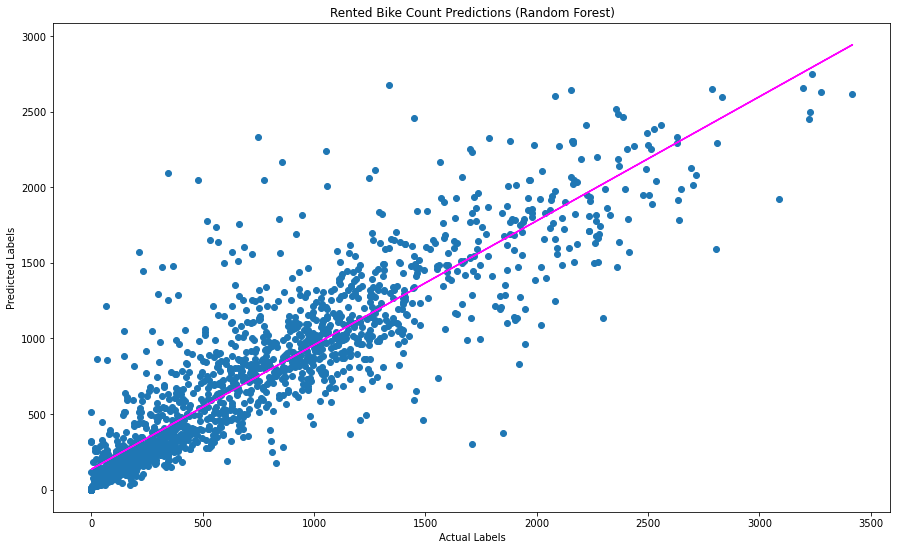

In [53]:
from sklearn.ensemble import RandomForestRegressor

# Create Preprocessing and Training Pipeline
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', RandomForestRegressor())])

# Fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train,(y_train))
print(model)
print('_'*125)

# Get Predictions
predictions = model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
mse = mean_squared_error(y_test, predictions)
print('MSE :', mse)
rmse = np.sqrt(mse)
print('RMSE :', rmse)
r2 = r2_score(y_test,predictions)
print('R2 Score :', r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Random Forest)')
z= np.polyfit(y_test, predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

### B. Gradient Boosting

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [10, 11, 12]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                   9])])),
                ('regressor', GradientBoostingRegressor())])
_____________________________________________________________________________________________________________________________
MSE : 93639.86709916157
RMSE : 306.00631872424066
R2 Score : 0.7734284998318994
________________________________

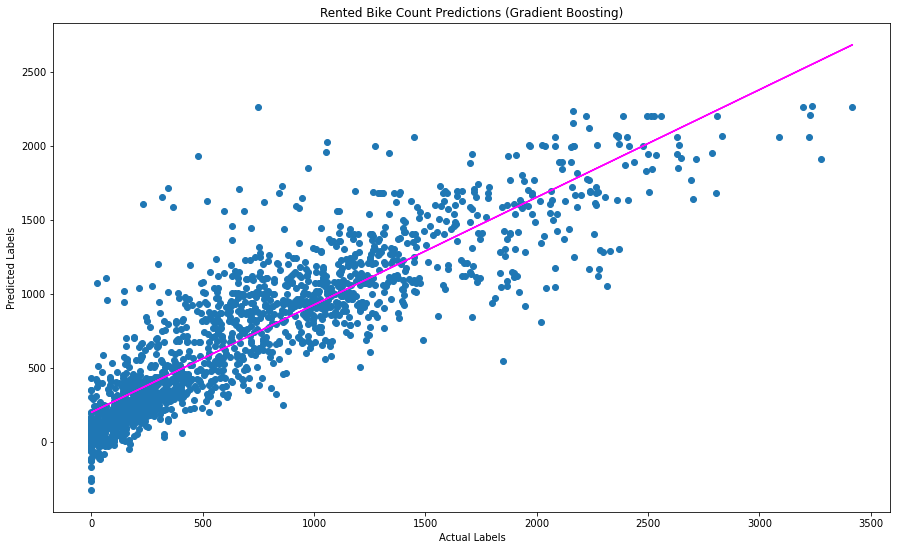

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Preprocessing and Training Pipeline
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('regressor', GradientBoostingRegressor())])

# Fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train,(y_train))
print(model)
print('_'*125)

# Get Predictions
predictions = model.predict(X_test)

# Display metrics
from sklearn.metrics import r2_score, mean_squared_error
mse = mean_squared_error(y_test, predictions)
print('MSE :', mse)
rmse = np.sqrt(mse)
print('RMSE :', rmse)
r2 = r2_score(y_test,predictions)
print('R2 Score :', r2)
print('_'*125)

# Plot predicted vs actual
plt.figure(figsize=(15,9))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Rented Bike Count Predictions (Gradient Boosting)')
z= np.polyfit(y_test, predictions,1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()